# Audio Fingerprinting Algorithm Visualization

This notebook provides a step-by-step visualization of how the audio fingerprinting algorithm works. We'll use a simple audio example and show the transformation at each stage of the process.

In [1]:
# Import necessary libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure, iterate_structure, binary_erosion
import random
from IPython.display import Audio

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('ggplot')

## Stage 1: Audio Loading and Preprocessing

We'll start by loading a simple audio file. For this example, we'll use a short music clip.

In [2]:
# For this example, we'll use a sample audio file from librosa

audio_path = librosa.ex('trumpet')

# Load the audio file
y, sr = librosa.load(audio_path, sr=11025)

# Get audio duration in seconds
duration = librosa.get_duration(y=y, sr=sr)

print(f"Audio duration: {duration:.2f} seconds")
print(f"Sample rate: {sr} Hz")
print(f"Number of samples: {len(y)}")
print(f"First few amplitude values: {y[:10]}")

# Play the audio
Audio(y, rate=sr)

Audio duration: 5.33 seconds
Sample rate: 11025 Hz
Number of samples: 58801
First few amplitude values: [-7.5785816e-04 -4.6252459e-04  2.7790666e-04 -5.8845617e-04
  1.0400219e-03  1.2945943e-03  6.2759966e-05 -2.3838785e-03
  1.8657707e-03 -8.5859001e-04]


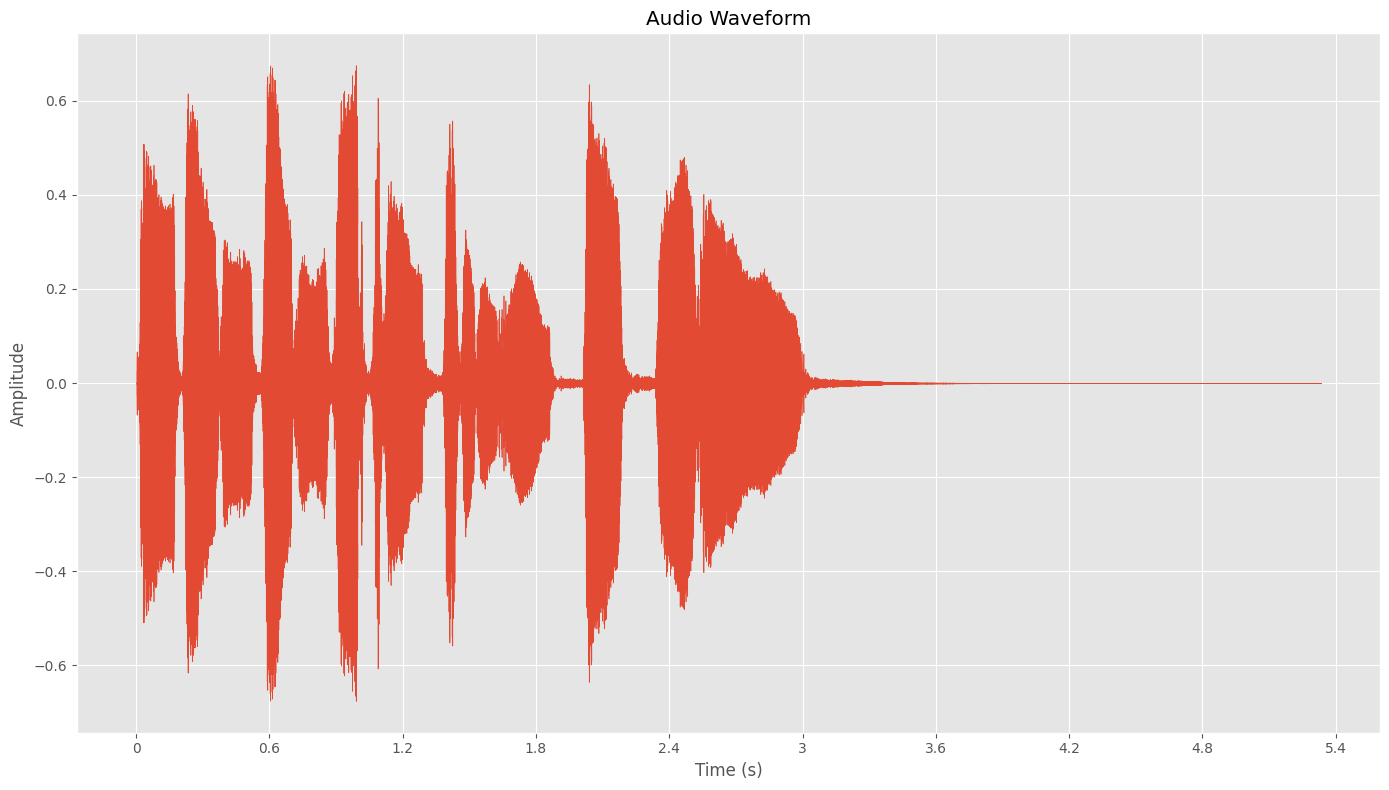

In [8]:
# Visualize the waveform
plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

The waveform above shows the amplitude of the audio signal over time. Each point represents how loud the sound is at that moment. This is the raw audio data in the time domain.

## Stage 2: Spectrogram Computation

Convert the time-domain signal to a frequency-domain representation using the Short-Time Fourier Transform (STFT). This gives us a spectrogram that shows how the frequency content changes over time.

In [7]:
# Compute the spectrogram using Short-Time Fourier Transform (STFT)
n_fft = 1024
hop_length = 512
S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

print(f"Spectrogram shape: {S.shape}")
print(f"Number of frequency bins: {S.shape[0]}")
print(f"Number of time frames: {S.shape[1]}")
print(f"Sample of spectrogram values:\n{S[:5, :5]}")

Spectrogram shape: (513, 115)
Number of frequency bins: 513
Number of time frames: 115
Sample of spectrogram values:
[[1.0002081e-03 5.1621074e-04 2.0369019e-04 1.8195142e-05 1.7287760e-04]
 [4.9725093e-04 5.3138146e-04 3.2963240e-04 4.1600387e-04 1.5132742e-04]
 [1.4702515e-03 7.8481709e-04 7.1418099e-04 8.0681429e-04 5.8611791e-04]
 [3.0899430e-03 2.1937504e-04 3.1031008e-04 4.2110682e-04 8.3879754e-04]
 [4.4451649e-03 3.9838991e-04 1.9019299e-04 4.3732904e-05 4.0169127e-04]]


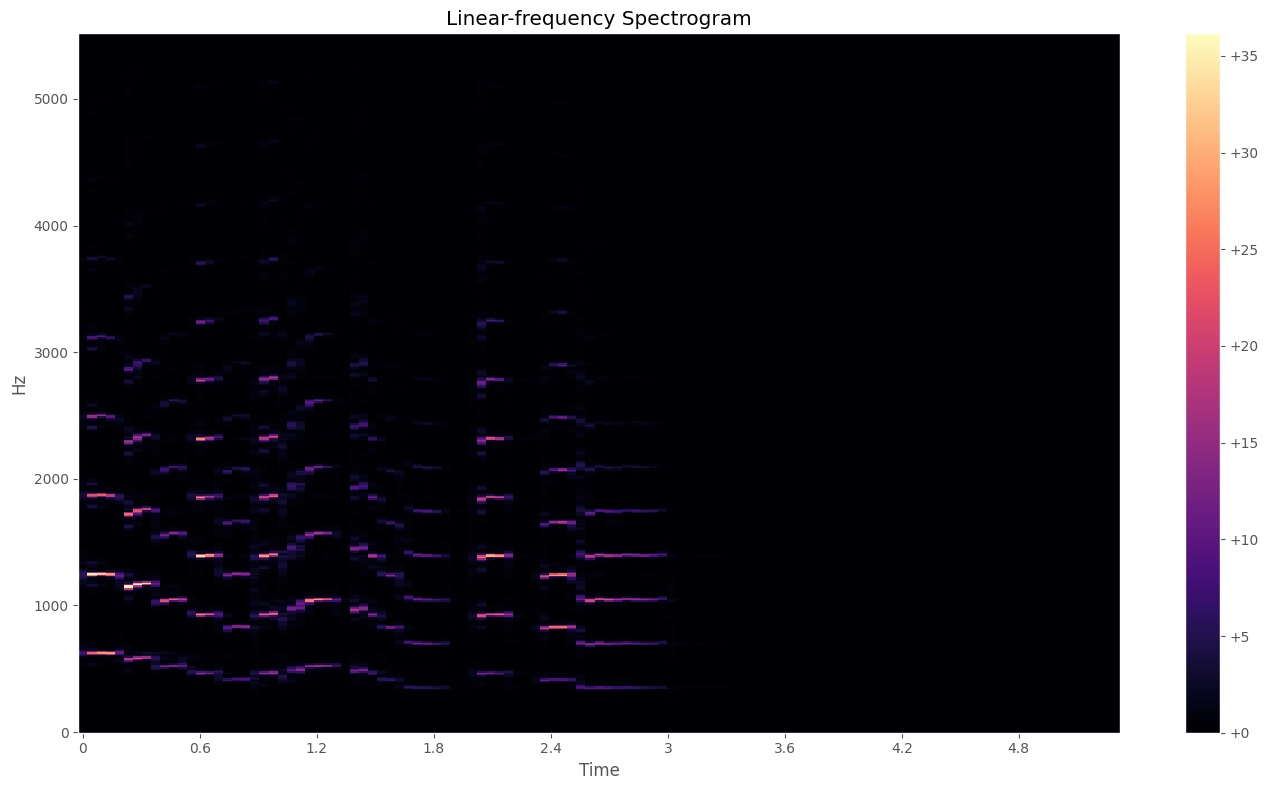

In [8]:
# Visualize the spectrogram
plt.figure()
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f')
plt.title('Linear-frequency Spectrogram')
plt.tight_layout()
plt.show()

The spectrogram above shows the frequency content of the audio over time:
- The x-axis represents time
- The y-axis represents frequency
- The color represents the magnitude (loudness) of each frequency at each time

Brighter colors indicate stronger presence of that frequency at that time.

## Stage 3: Conversion to Decibels

Convert the spectrogram to a logarithmic scale (decibels), which better represents how humans perceive sound.

In [9]:
# Convert to log scale (dB) and normalize
S_db = librosa.amplitude_to_db(S, ref=np.max)

print(f"dB range: {np.min(S_db):.2f} to {np.max(S_db):.2f} dB")
print(f"Sample of dB values:\n{S_db[:5, :5]}")

dB range: -80.00 to 0.00 dB
Sample of dB values:
[[-80.       -80.       -80.       -80.       -80.      ]
 [-80.       -80.       -80.       -80.       -80.      ]
 [-80.       -80.       -80.       -80.       -80.      ]
 [-80.       -80.       -80.       -80.       -80.      ]
 [-78.207954 -80.       -80.       -80.       -80.      ]]


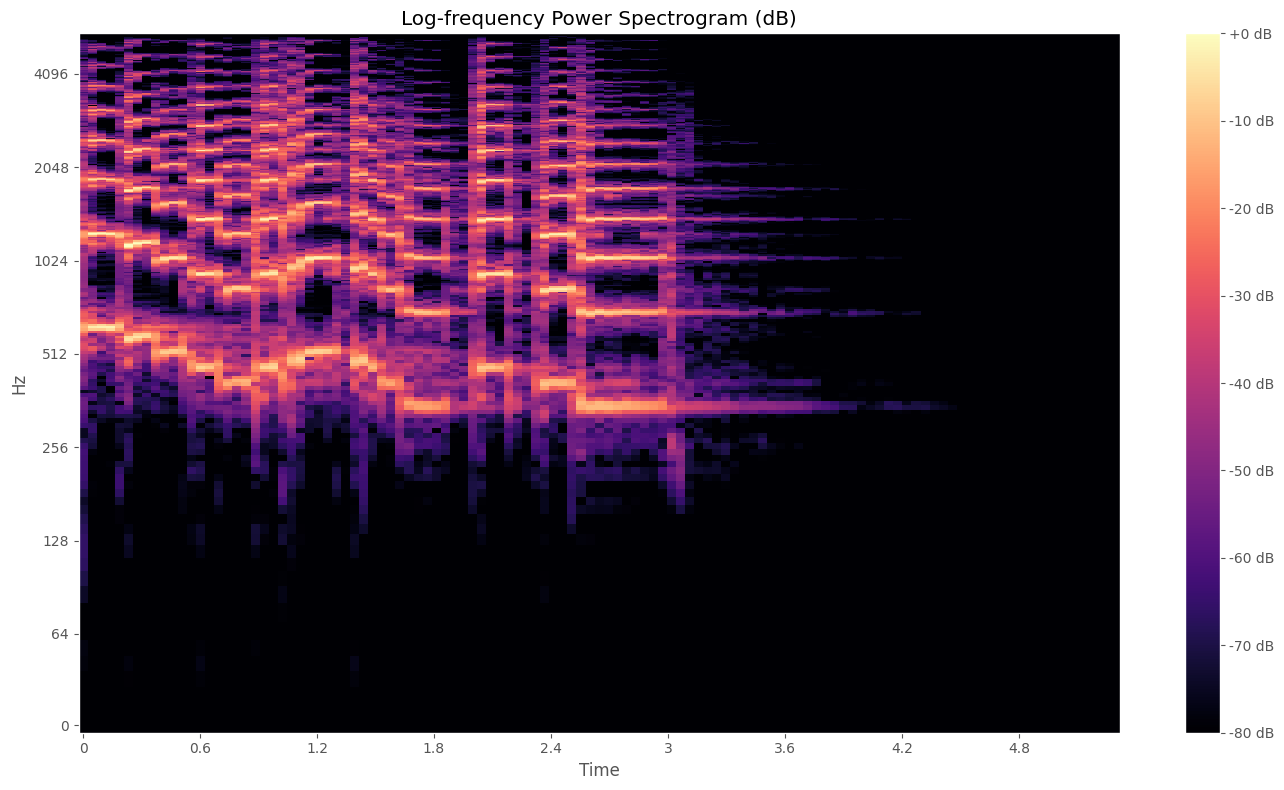

In [10]:
# Visualize the dB spectrogram
plt.figure()
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency Power Spectrogram (dB)')
plt.tight_layout()
plt.show()

The decibel-scaled spectrogram provides a better visualization of the audio content:
- 0 dB represents the loudest part of the audio
- Negative values represent quieter sounds
- The logarithmic scale compresses the dynamic range, making quieter sounds more visible

## Stage 4: Peak Finding

Identify local peaks in the spectrogram - points that are louder than their surrounding points.

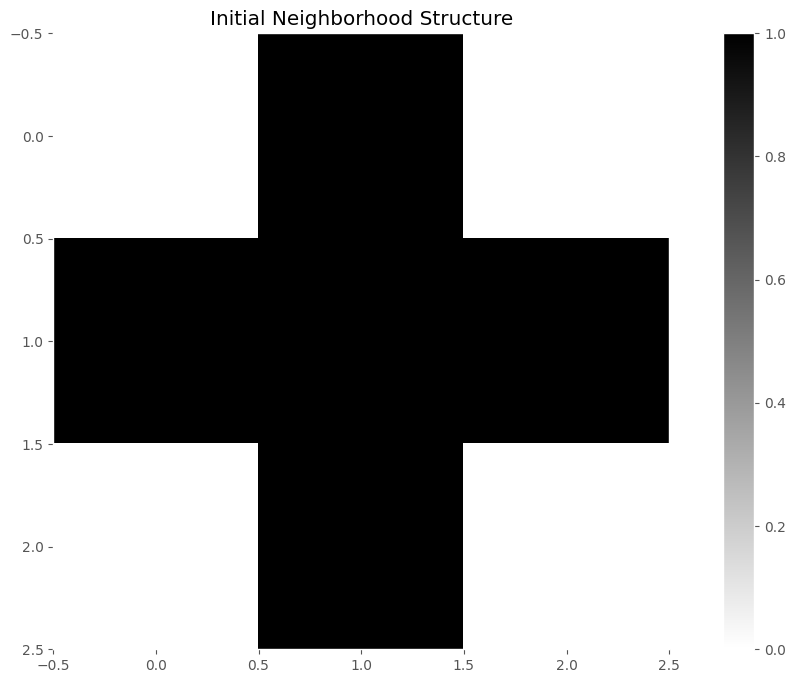

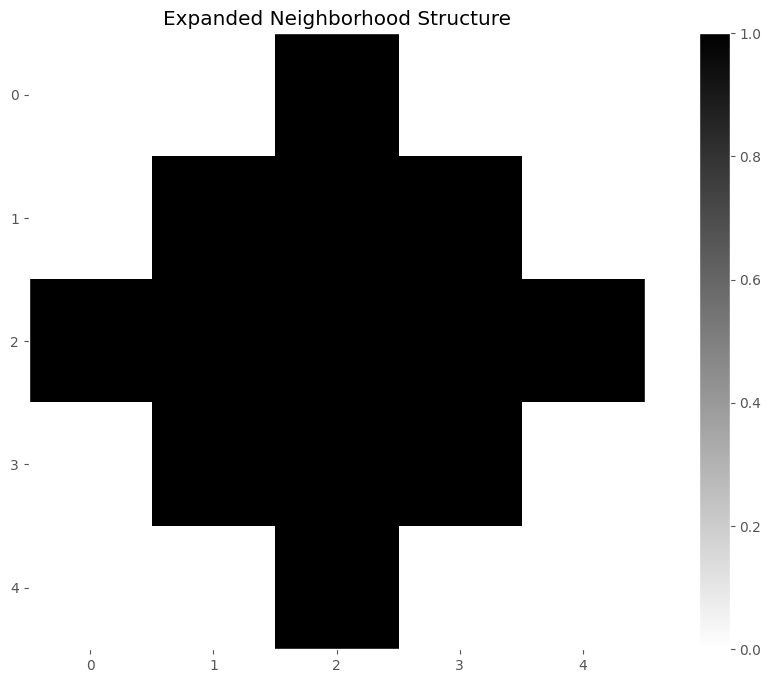

In [11]:
# Create the neighborhood structure
neighborhood = generate_binary_structure(2, 1)

# Visualize the initial neighborhood structure
plt.figure()
plt.imshow(neighborhood, cmap='binary')
plt.title('Initial Neighborhood Structure')
plt.colorbar()
plt.grid(False)
plt.show()

# Expand the neighborhood
neighborhood = iterate_structure(neighborhood, 2)

# Visualize the expanded neighborhood structure
plt.figure()
plt.imshow(neighborhood, cmap='binary')
plt.title('Expanded Neighborhood Structure')
plt.colorbar()
plt.grid(False)
plt.show()

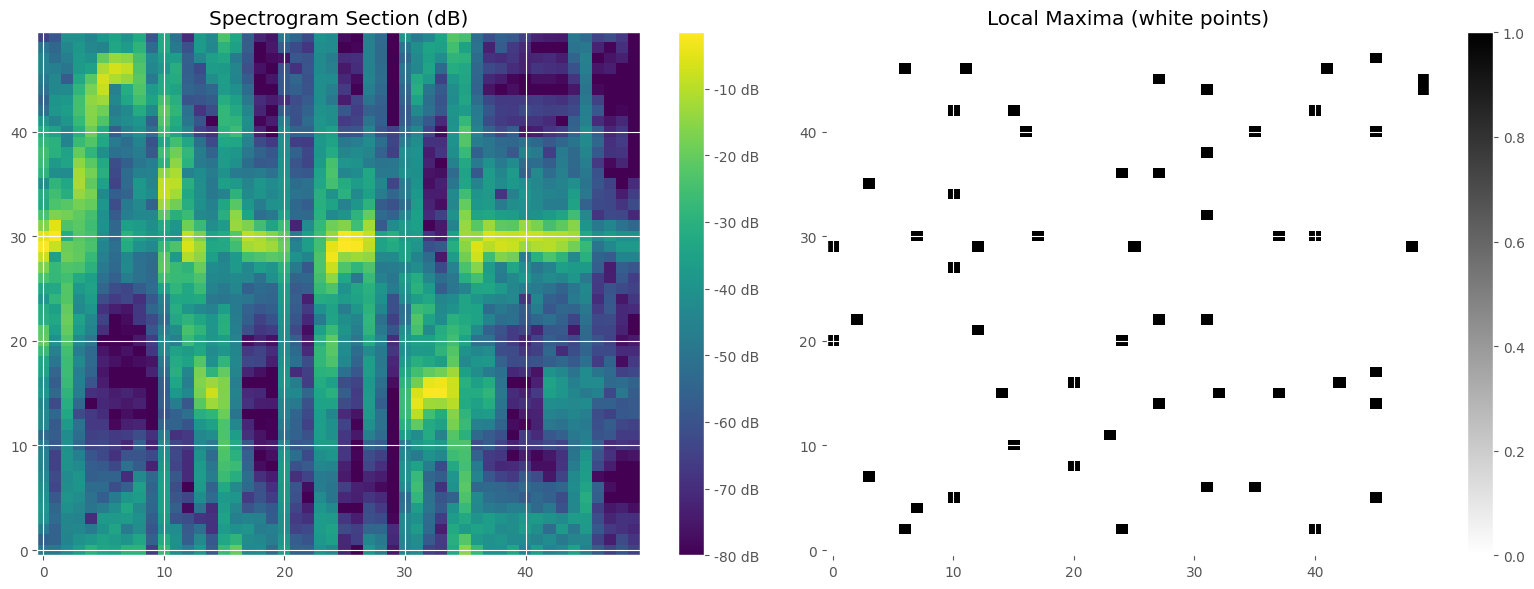

Number of local maxima in the entire spectrogram: 24974


In [12]:
# Find local maxima
local_max = maximum_filter(S_db, footprint=neighborhood) == S_db

# Visualize a small section of the spectrogram and its local maxima
# Let's take a 50x50 section for better visibility
start_freq, start_time = 100, 20
section_size = 50

# Extract sections
S_db_section = S_db[start_freq:start_freq+section_size, start_time:start_time+section_size]
local_max_section = local_max[start_freq:start_freq+section_size, start_time:start_time+section_size]

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original spectrogram section
im1 = ax1.imshow(S_db_section, origin='lower', aspect='auto', cmap='viridis')
ax1.set_title('Spectrogram Section (dB)')
plt.colorbar(im1, ax=ax1, format='%+2.0f dB')

# Local maxima
im2 = ax2.imshow(local_max_section, origin='lower', aspect='auto', cmap='binary')
ax2.set_title('Local Maxima (white points)')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Count the number of local maxima
print(f"Number of local maxima in the entire spectrogram: {np.sum(local_max)}")

The images above show:
1. Left: A section of the spectrogram
2. Right: The local maxima in that section (white points)

Each white point in the right image represents a location where the value is higher than all its neighbors (as defined by our neighborhood structure).

## Stage 5: Thresholding

Apply a threshold to keep only the significant peaks - those that are not only local maxima but also loud enough.

Median dB value: -80.00 dB
Threshold: -65.00 dB
Number of peaks after thresholding: 813


C:\Users\USER\AppData\Local\Temp\ipykernel_8096\1242081399.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\USER\Documents\Jace-0\FSO\PROJECT\Music recognition app\music_recognition_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


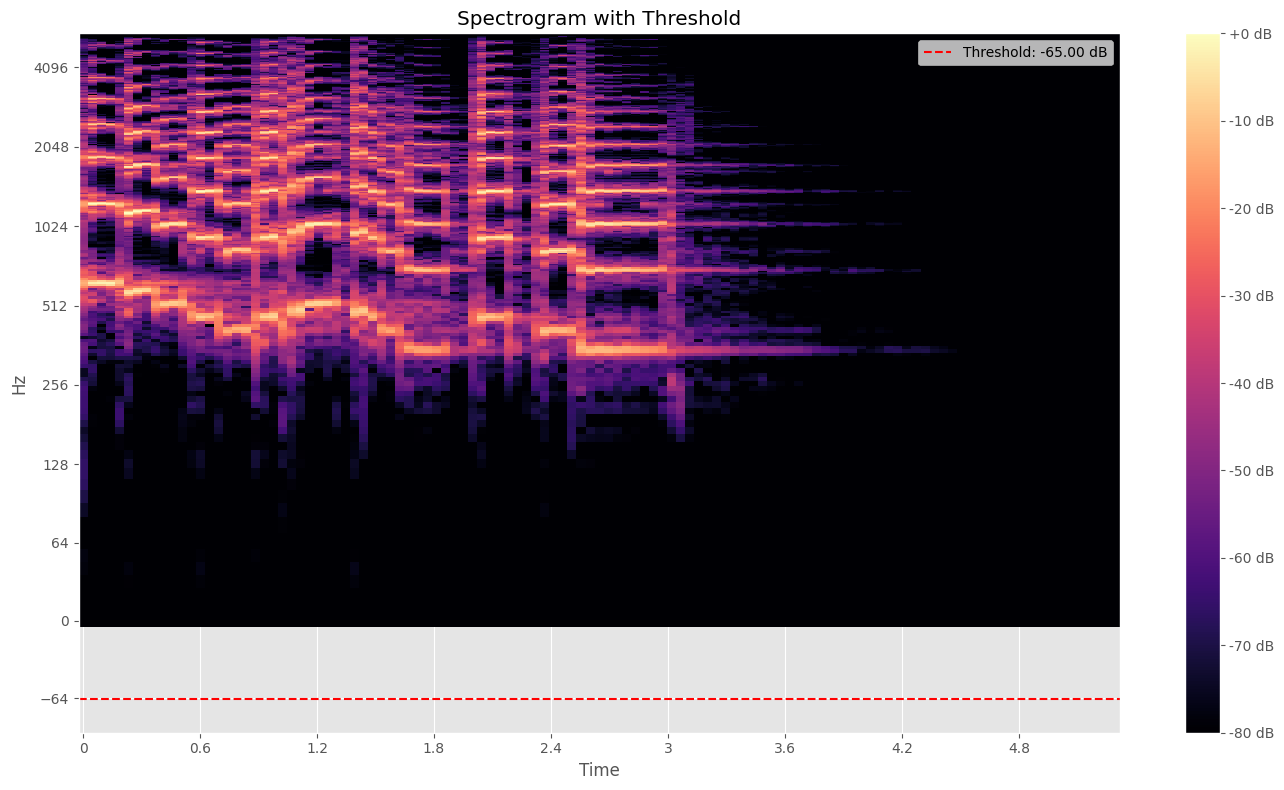

In [13]:
# Apply threshold to find significant peaks
threshold = np.median(S_db) + 15
peaks = np.logical_and(local_max, S_db > threshold)

print(f"Median dB value: {np.median(S_db):.2f} dB")
print(f"Threshold: {threshold:.2f} dB")
print(f"Number of peaks after thresholding: {np.sum(peaks)}")

# Visualize the threshold on the spectrogram
plt.figure()
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f} dB')
plt.title('Spectrogram with Threshold')
plt.legend()
plt.tight_layout()
plt.show()

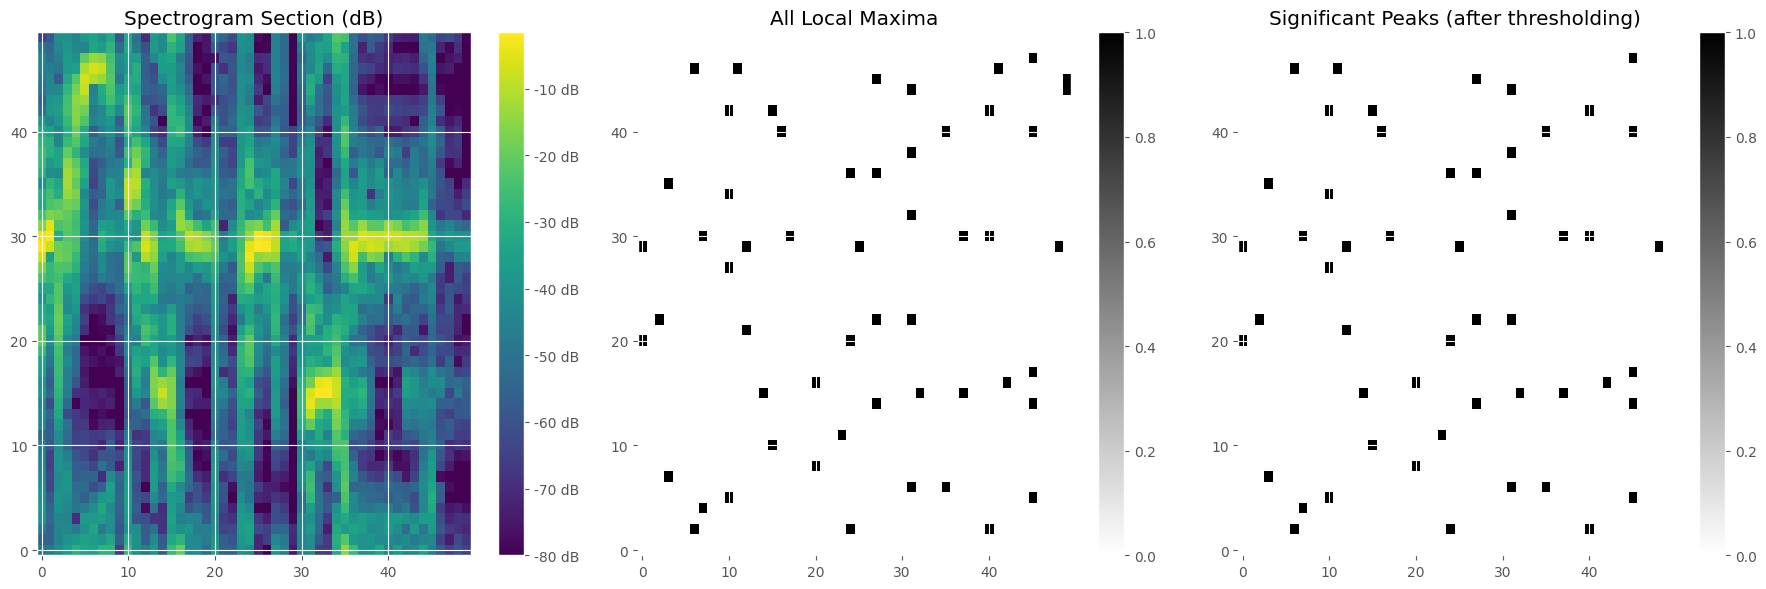

In [14]:
# Visualize the same section with both local maxima and thresholded peaks
peaks_section = peaks[start_freq:start_freq+section_size, start_time:start_time+section_size]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Original spectrogram section
im1 = ax1.imshow(S_db_section, origin='lower', aspect='auto', cmap='viridis')
ax1.set_title('Spectrogram Section (dB)')
plt.colorbar(im1, ax=ax1, format='%+2.0f dB')

# Local maxima
im2 = ax2.imshow(local_max_section, origin='lower', aspect='auto', cmap='binary')
ax2.set_title('All Local Maxima')
plt.colorbar(im2, ax=ax2)

# Thresholded peaks
im3 = ax3.imshow(peaks_section, origin='lower', aspect='auto', cmap='binary')
ax3.set_title('Significant Peaks (after thresholding)')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()

The images above show:
1. Left: The original spectrogram section,
2. Middle: All local maxima in that section,
3. Right: Only the significant peaks after applying the threshold,


## Stage 6: Extract Peak Coordinates,
Extract the coordinates (frequency and time) of the significant peaks we've identified."

In [15]:
# Get the coordinates of peaks,
peak_coords = np.where(peaks)
frequencies = peak_coords[0]
times = peak_coords[1]

print(f"Number of peaks: {len(frequencies)}")
print(f"First 5 frequency bins: {frequencies[:5]}")
print(f"First 5 time frames: {times[:5]}")
      
# Limit number of peaks for faster processing,
max_peaks = min(3000, max(300, int(duration * 50)))  # 50 peaks per second, up to 3000,
if len(frequencies) > max_peaks:
    # Get the values at the peak locations,
    peak_values = S_db[peaks]
    # Get indices of the highest values,
    top_indices = np.argsort(peak_values)[-max_peaks:]
    # Keep only the loudest peaks,
    frequencies = frequencies[top_indices]
    times = times[top_indices]

print(f"Number of peaks after limiting: {len(frequencies)}")

Number of peaks: 813
First 5 frequency bins: [18 19 20 20 21]
First 5 time frames: [22  4 31 66 19]
Number of peaks after limiting: 300


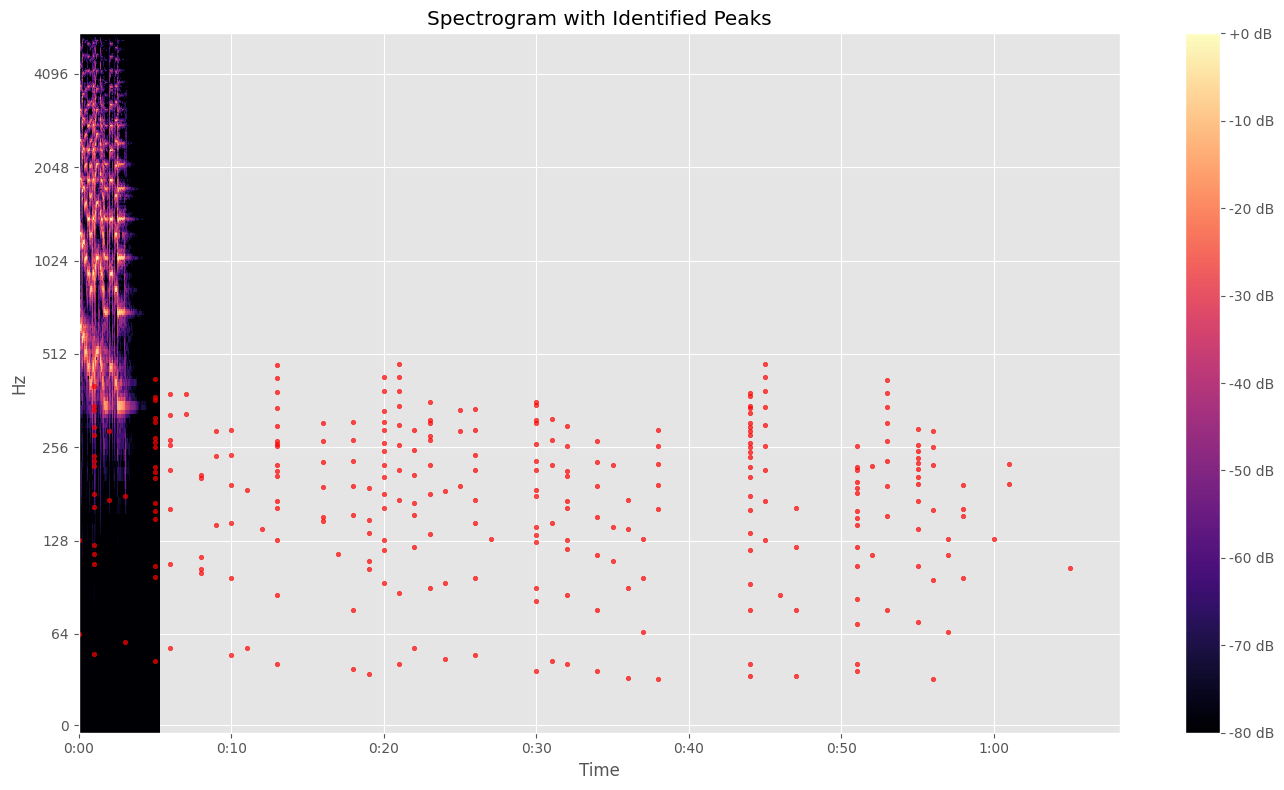

In [16]:
# Visualize the peaks on the spectrogram
plt.figure(figsize=(14, 8))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.scatter(times, frequencies, s=10, c='r', alpha=0.7)
plt.title('Spectrogram with Identified Peaks')
plt.tight_layout(),
plt.show()

The image above shows the spectrogram with all the identified peaks marked as red dots. These peaks represent the most prominent frequency components at different times in the audio.

# Stage 7: Create Fingerprint Hash Tokens
Now we'll create fingerprint tokens by connecting each peak (anchor point) with other peaks in its target zone. This is the core of the fingerprinting algorithm.

In [ ]:
# Define the target zone parameters
min_delta = 1
max_delta = min(50, max(10, int(duration / 10)))

# Wider window for longer songs
print(f"Audio duration: {duration:.2f} seconds")
print(f"Target zone time window: {min_delta} to {max_delta} frames")
print(f"Number of peaks to process: {len(frequencies)}")

Audio duration: 5.33 seconds
Target zone time window: 1 to 10 frames
Number of peaks to process: 300


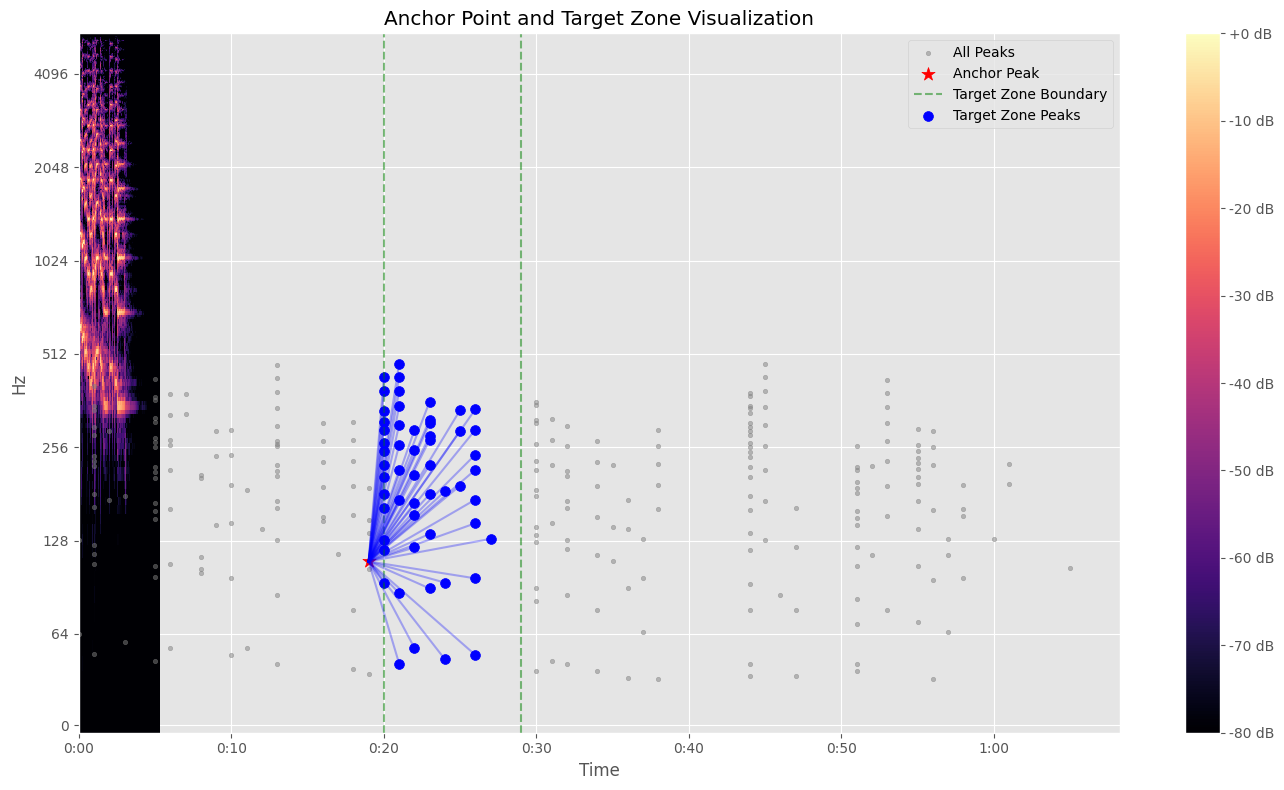

Anchor point: Frequency bin 110, Time frame 19
Number of peaks in target zone: 55


In [21]:
# Visualize the target zone concept
# A random peak as an anchor

if len(frequencies) > 0:
    anchor_idx = np.random.randint(0, len(frequencies))
    anchor_freq = frequencies[anchor_idx]
    anchor_time = times[anchor_idx]

   # Find all peaks in the target zone
    target_zone_indices = []
    for i in range(len(frequencies)):
        if i != anchor_idx:  # Skip the anchor itself
            time_delta = times[i] - anchor_time
            if min_delta <= time_delta <= max_delta:
                target_zone_indices.append(i)

    # Visualize

    plt.figure(figsize=(14, 8))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    
    # Plot all peaks,
    plt.scatter(times, frequencies, s=10, c='gray', alpha=0.5, label='All Peaks')
    
    # Plot the anchor,
    plt.scatter(anchor_time, anchor_freq, s=100, c='r', marker='*', label='Anchor Peak')
    
    # Plot the target zone,
    plt.axvline(x=anchor_time + min_delta, color='g', linestyle='--', alpha=0.5, label='Target Zone Boundary')
    plt.axvline(x=anchor_time + max_delta, color='g', linestyle='--', alpha=0.5)
    
    # Plot peaks in the target zone,
    if target_zone_indices:
        target_freqs = frequencies[target_zone_indices]
        target_times = times[target_zone_indices]
        plt.scatter(target_times, target_freqs, s=50, c='b', marker='o', label='Target Zone Peaks')
        
        # Draw lines from anchor to targets,
        for i in range(len(target_freqs)):
            plt.plot([anchor_time, target_times[i]], [anchor_freq, target_freqs[i]], 'b-', alpha=0.3)
    
    plt.title('Anchor Point and Target Zone Visualization')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    print(f"Anchor point: Frequency bin {anchor_freq}, Time frame {anchor_time}")
    print(f"Number of peaks in target zone: {len(target_zone_indices)}")
else:
    print("No peaks found to visualize.")


Total number of fingerprint tokens: 6220
Displaying a random sample of 1000 tokens for clarity


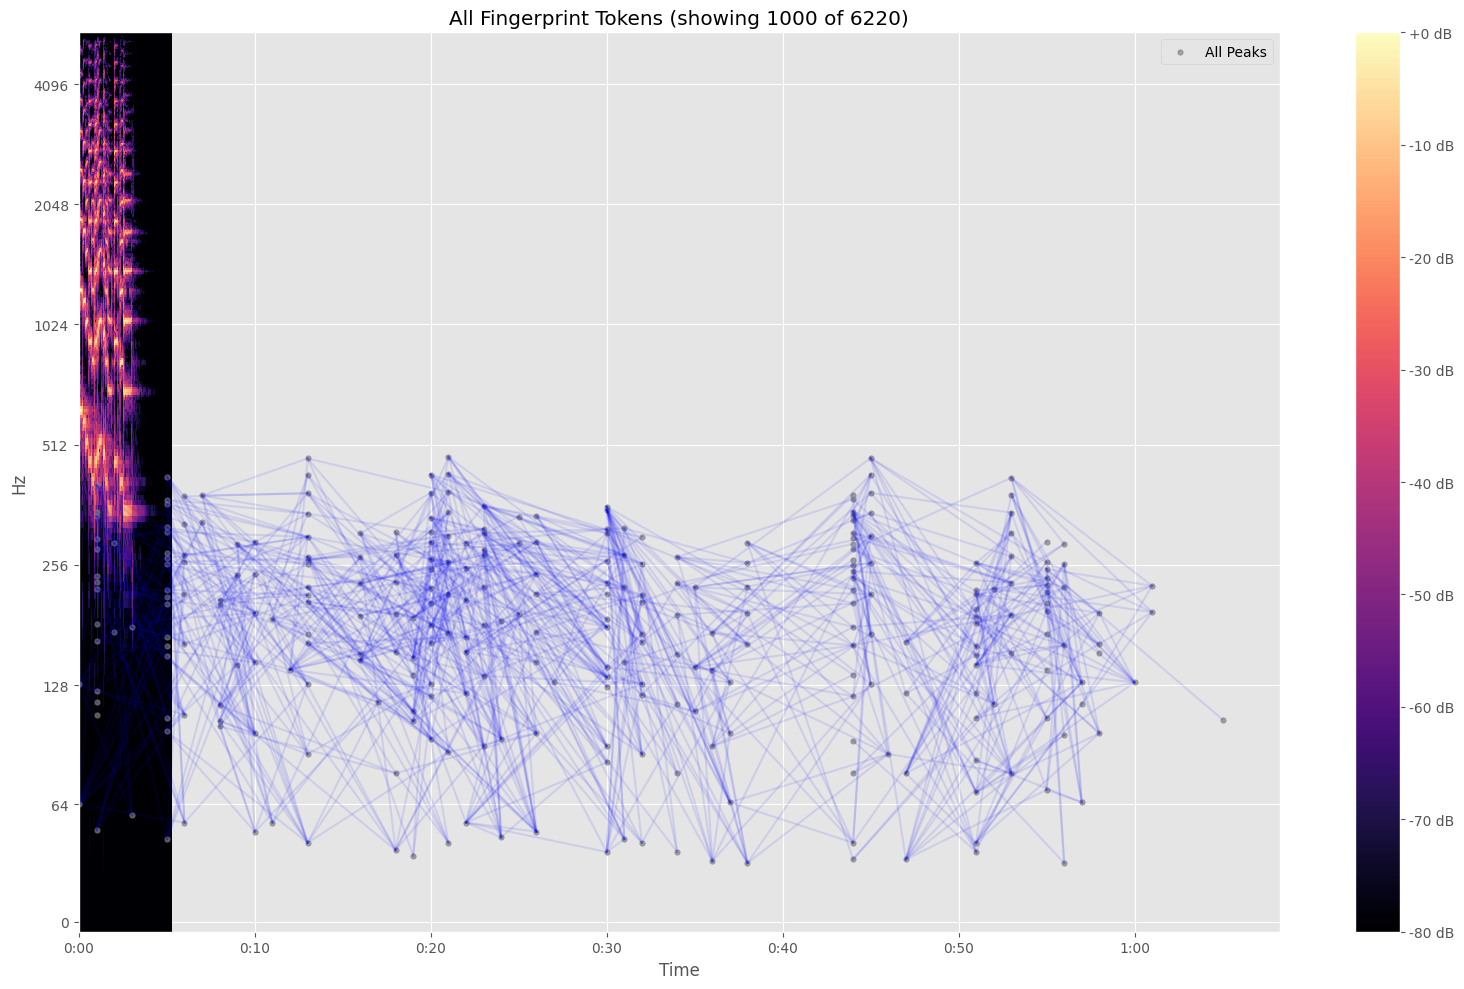

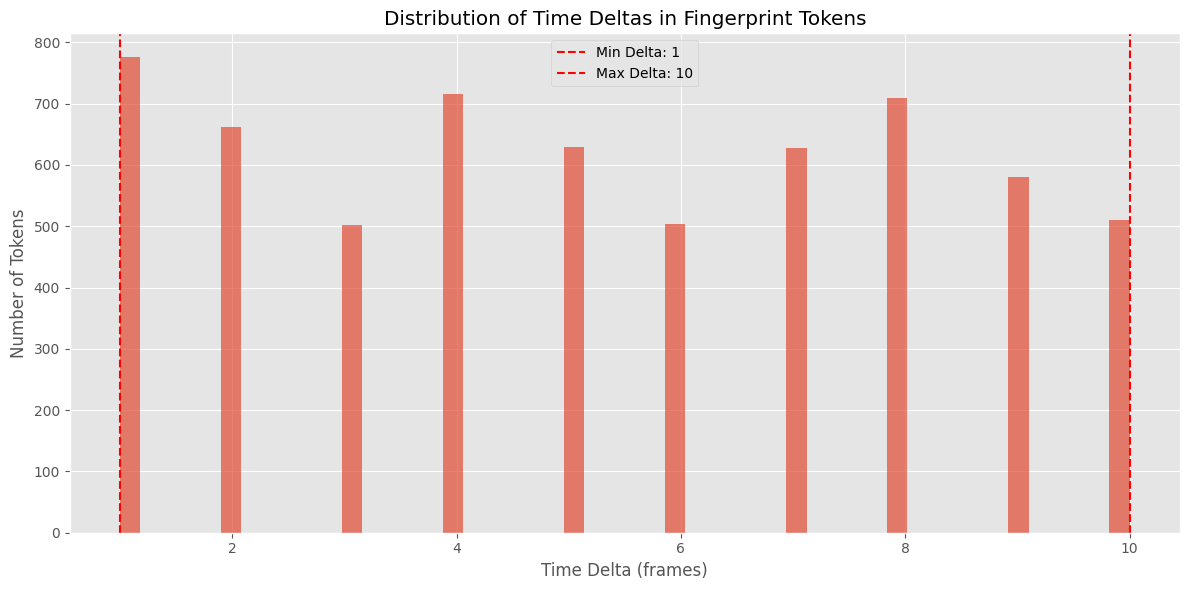

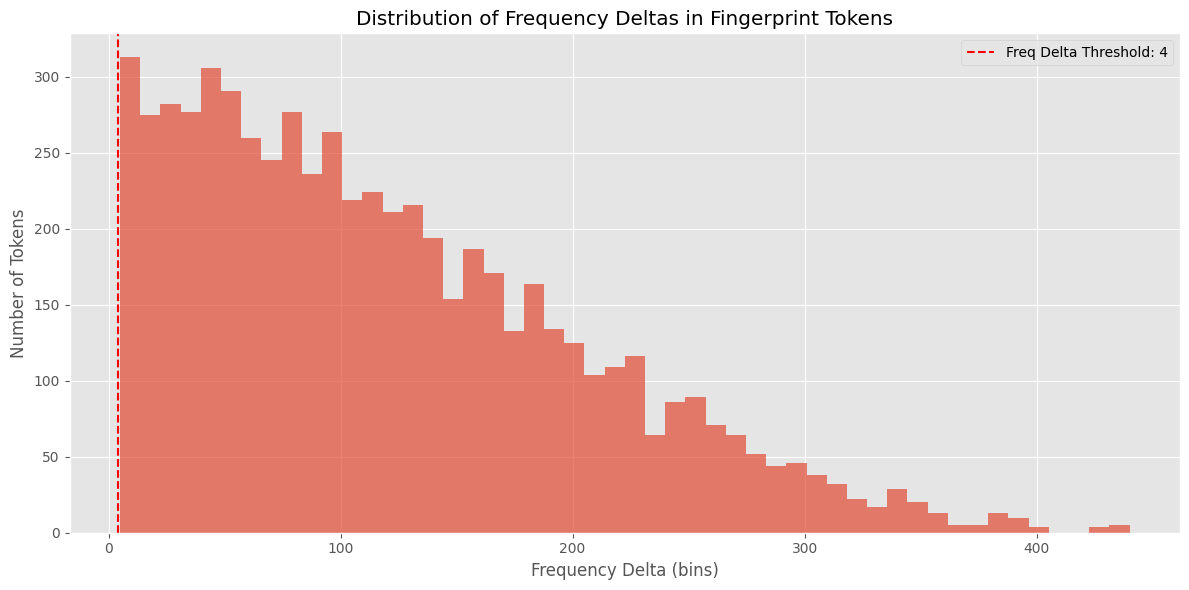

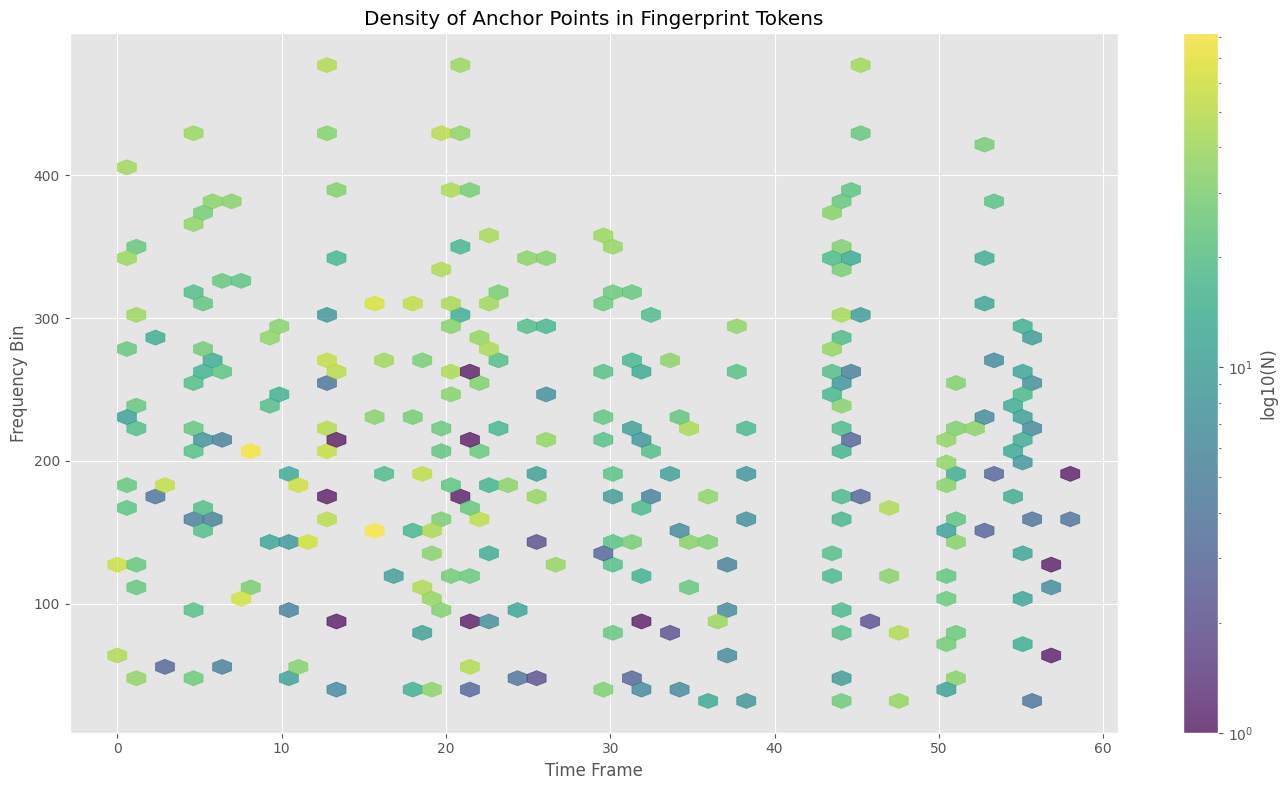

In [22]:

freq_delta_threshold=4 
max_tokens_to_display=1000
# Create a figure
plt.figure(figsize=(16, 10))

# Plot the spectrogram
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

# Plot all peaks
plt.scatter(times, frequencies, s=15, c='gray', alpha=0.7, label='All Peaks')

# Generate all tokens (same logic as in the fingerprinting function)
all_tokens = []
for i in range(len(frequencies)):
    freq_anchor = frequencies[i]
    time_anchor = times[i]
    
    for j in range(i + 1, len(frequencies)):
        freq_target = frequencies[j]
        time_target = times[j]
        time_delta = time_target - time_anchor
        
        if min_delta <= time_delta <= max_delta:
            freq_delta = abs(freq_target - freq_anchor)
            if freq_delta > freq_delta_threshold:
                token = (freq_anchor, freq_target, time_delta, time_anchor)
                all_tokens.append((time_anchor, freq_anchor, time_target, freq_target))

# Print statistics
print(f"Total number of fingerprint tokens: {len(all_tokens)}")

# If we have too many tokens to display, sample them
tokens_to_plot = all_tokens
if len(all_tokens) > max_tokens_to_display:
    print(f"Displaying a random sample of {max_tokens_to_display} tokens for clarity")
    tokens_to_plot = random.sample(all_tokens, max_tokens_to_display)

# Plot the connections between anchor and target points
for token in tokens_to_plot:
    time_anchor, freq_anchor, time_target, freq_target = token
    plt.plot([time_anchor, time_target], [freq_anchor, freq_target], 'b-', alpha=0.1)


plt.title(f'All Fingerprint Tokens (showing {len(tokens_to_plot)} of {len(all_tokens)})')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Create a histogram of time deltas
if len(all_tokens) > 0:
    time_deltas = [token[2] - token[0] for token in all_tokens]
    
    plt.figure(figsize=(12, 6))
    plt.hist(time_deltas, bins=50, alpha=0.7)
    plt.axvline(x=min_delta, color='r', linestyle='--', label=f'Min Delta: {min_delta}')
    plt.axvline(x=max_delta, color='r', linestyle='--', label=f'Max Delta: {max_delta}')
    plt.xlabel('Time Delta (frames)')
    plt.ylabel('Number of Tokens')
    plt.title('Distribution of Time Deltas in Fingerprint Tokens')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Histogram of frequency deltas
    freq_deltas = [abs(token[3] - token[1]) for token in all_tokens]
    
    plt.figure(figsize=(12, 6))
    plt.hist(freq_deltas, bins=50, alpha=0.7)
    plt.axvline(x=freq_delta_threshold, color='r', linestyle='--', 
                label=f'Freq Delta Threshold: {freq_delta_threshold}')
    plt.xlabel('Frequency Delta (bins)')
    plt.ylabel('Number of Tokens')
    plt.title('Distribution of Frequency Deltas in Fingerprint Tokens')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Heatmap showing token density
if len(all_tokens) > 0:
    plt.figure(figsize=(14, 8))
    
    # 2D histogram of anchor points
    anchor_times = [token[0] for token in all_tokens]
    anchor_freqs = [token[1] for token in all_tokens]
    
    plt.hexbin(anchor_times, anchor_freqs, gridsize=50, cmap='viridis', 
                bins='log', alpha=0.7)
    
    plt.colorbar(label='log10(N)')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency Bin')
    plt.title('Density of Anchor Points in Fingerprint Tokens')
    plt.tight_layout()
    plt.show()